## Duomenys:
CIFAR-10 duomenų rinkinys yra sudarytas iš 50000 mokymo ir 10000 testavimo duomenų.
Kiekvienas duomenų rinkinys yra 32x32x3 (RGB) dydžio. Yra 10 klasių.
0: lektuvas
1: automobilis
2: paukštis
3: katė
4: elnias
5: šuo
6: varlė
7: arklys
8: laivas
9: sunkvežimis
Kiekvienas paveikslėlis turi priskirtą etiketę nuo 0 iki 9, nurodančią paveikslėlio klasę.
\
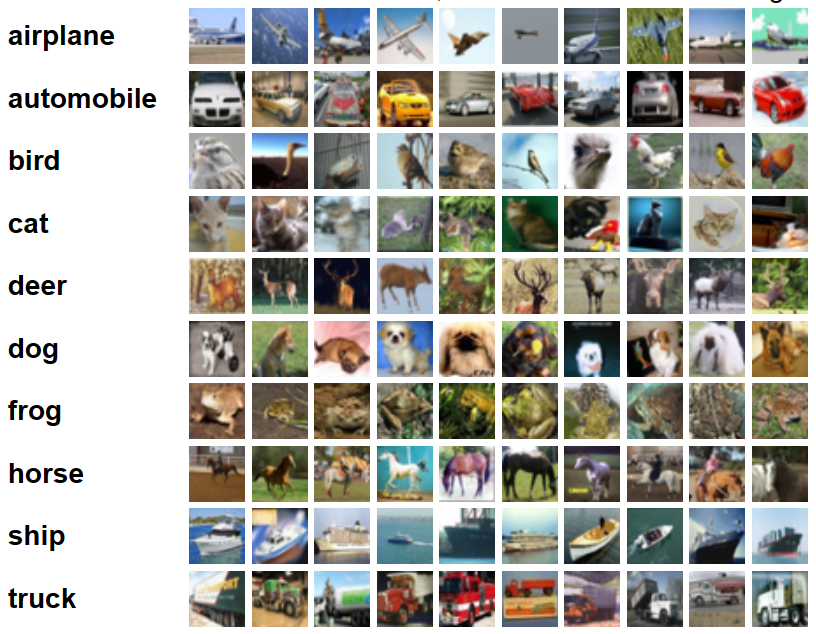

# Hipotezė:
CNN turėtų turėti didesnį accuracy už MLP tinklą ir MLP tinklas turėtų turėti didesnį accuracy už kNN.

## Tikslas:
Sukurti ir palyginti mašininio mokymosi modelius vaizdų klasifikacijai CIFAR-10 duomenų rinkinyje. Bus panaudojami Konvoliuciniai Neuroniniai Tinklai (CNN), Daugiasluoksniai Perceptronai (MLP) ir tradicinio mašininio mokymosi metodas - k-artiniausių kaimynų (k-NN) algoritmas.

# Duomenų vizualizacija

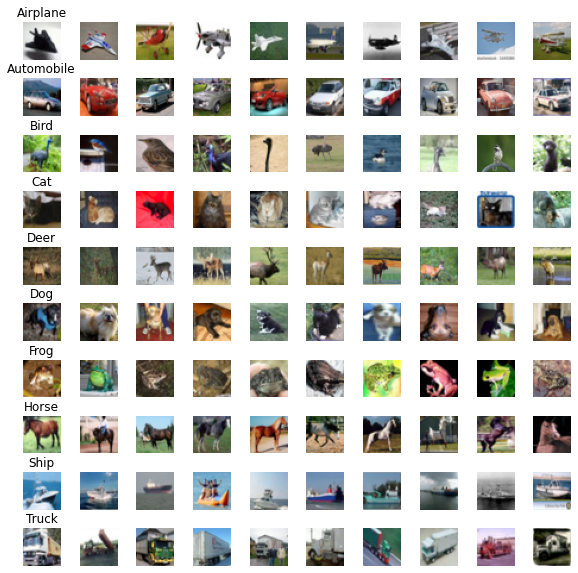

In [149]:
import matplotlib.pyplot as plt
from keras.datasets import cifar10

(trainX, trainY), (testX, testY) = cifar10.load_data()

# pavadinimai
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Parodyti po 10 atsitiktiniu nuotrauku is train seto
fig, ax = plt.subplots(10, 10, figsize=(10,10))
for i in range(10):
    for j in range(10):
        image = trainX[trainY.ravel() == i][j]
        ax[i, j].imshow(image)
        ax[i, j].axis('off')
    ax[i, 0].set_title(labels[i])
plt.subplots_adjust(hspace=0.5)
plt.show()




Daugiau apdoroti duomenų nereikia, nes tai yra tiesiog nuotraukos ir CIFAR-10 yra oficialus mokslininkų naudojamas dataset iš Keras bibliotekos

In [136]:

# Importuojamos bibliotekos ir cifar10 duomenys
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import numpy as np
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [137]:
# CNN Užkraunamas CIFAR-10 duomenų rinkinys
# Duomenų valyti nereikia, nes jie jau yra paruošti naudojimui.
def load_dataset():
 (trainX, trainY), (testX, testY) = cifar10.load_data()
 # Kovenrtuojame pavadinimus į kategorijas su one-hot encoding, nes turime 10 klasių. Pvz. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 # Y - kategorijos, X - paveikslėliai
 # Už mus jau paruošta testavimo ir mokymo duomenų rinkinio dalis
 trainY = to_categorical(trainY)
 testY = to_categorical(testY)
 return trainX, trainY, testX, testY
# paruošiami paveikslėliai, normalizacija
def prep_pixels(train, test):
 train_norm = train.astype('float32') # pakeičiame į float tipą
 test_norm = test.astype('float32') # pakeičiame į float tipą
 # normalizuojame nuo 0 iki 1
 train_norm = train_norm / 255.0 # nes 255 yra max RGB reikšmė
 test_norm = test_norm / 255.0
 return train_norm, test_norm

# CNN modelis
def cnn_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3))) # 32, 32, 3 - paveikslėlio dydis
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')) # ReLU, nes daznai naudojamas CNN, kernel_initializer='he_uniform' specialiai sukurtas naudoti su ReLU
 model.add(MaxPooling2D((2, 2))) # MaxPooling2D sumažina paveikslėlio dydį, kad sumažinti parametrų skaičių, panaikina šiek tiek triukšmo
 model.add(Dropout(0.2))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')) # padding='same' uztikrina, kad paveikslėlyje neprarastume daug informacijos, nepakeisime dydžio
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2))) 
 model.add(Dropout(0.2))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 # Einant gilyn į CNN, reikia didinti filtrų skaičių, nes MaxPooling2D sumažina paveikslėlio dydį, o mes norime išlaikyti informaciją ir išgauti daugiau savybių
 # (3, 3) - filtrų dydis
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2)) # Dropout - neleidžia modeliui per daug prisitaikyti prie duomenų
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dropout(0.2))
 model.add(Dense(10, activation='softmax')) # softmax, nes turime daugiau nei 2 klases
 opt = SGD(learning_rate=0.001, momentum=0.9) # SGD - Stochastic Gradient Descent, nes naudojamas didelis duomenų rinkinys, learning_rate - kaip greit koreguojami svoriai, momentum - kiek daug prideti pries tai buvusio svorio
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) # categorical_crossentropy, nes turime daugiau nei 2 klases
 model.summary()
 return model


In [138]:
# grafikai
def plotting(history):
 # loss funkcijos grafikas
 pyplot.subplot(211)
 pyplot.title('Cross Entropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train') # melyna linija - mokymo duomenys
 pyplot.plot(history.history['val_loss'], color='orange', label='test') # oranzine linija - testavimo duomenys
 # palikti vietos tarp grafikų
 pyplot.subplots_adjust(hspace=0.5)
 # accuracy grafikas
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['accuracy'], color='blue', label='train')
 pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
 # rodyti grafikus
 pyplot.show()
 pyplot.close()
 

In [139]:
# CNN main funkcija
def CNNMain():
 # užkraunam duomenis
 trainX, trainY, testX, testY = load_dataset()
 # paruošiam duomenų pixelius
 trainX, testX = prep_pixels(trainX, testX)
 # aprašom modelį
 model = cnn_model()
 # fittinam modelį
 history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY))
 _, acc = model.evaluate(testX, testY)
 print('Accuracy > %.2f' % (acc * 100.0))
 # grafikai
 plotting(history)
 test_images = testX
 test_labels = testY
 # testavimui naudojame 15 paveikslėlių
 predictions = model.predict(test_images[:15])

 # atspausdiname paveikslėlius ir jų klasę
 print('test1:')
 print(np.argmax(predictions, axis=1))
 print('test2:')
 # palyginame su tikromis klasėmis
 print(test_labels[:15])

 #lyginame su tikromis klasėmis ir spausdiname klasifikavimo ataskaitą
 number_of_samples = 50 # kiek paveikslėlių palyginsime
 predictions = np.argmax(model.predict(test_images[:number_of_samples]), axis=1) # modelio prognozės
 true_labels = np.argmax(test_labels[:number_of_samples], axis=1)  # tikros klasės
 print(classification_report(true_labels, predictions)) # spausdiname klasifikavimo ataskaitą

# Eksperimentai
## VGG modelis 1, 2, 3
## 50 epochu
### Mėlyna - mokymo duomenys
### Oranžine linija - testavimo duomenys
### 1 blokas: 70.90 accuracy
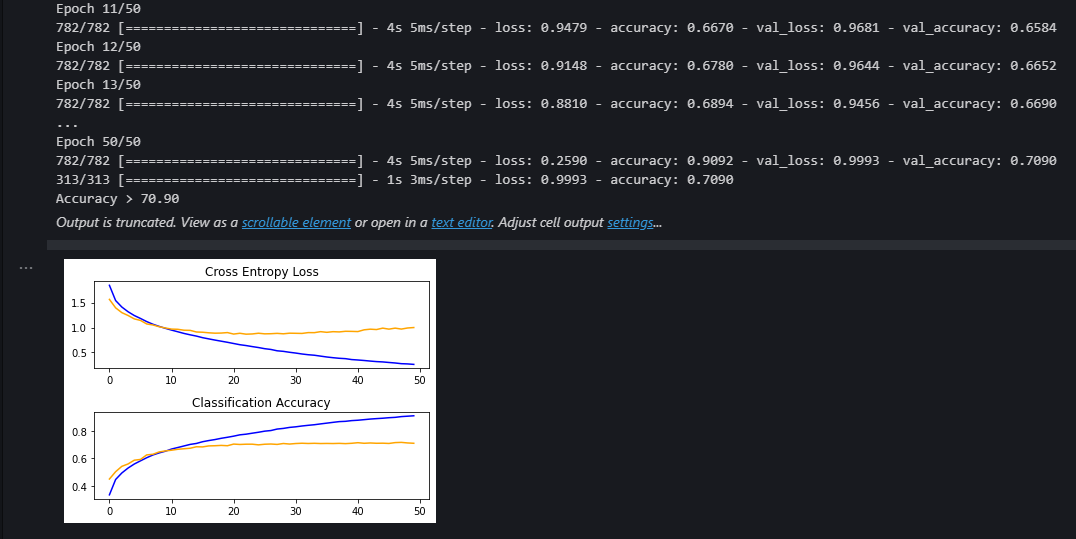
### 2 blokai: 78.38 accuracy
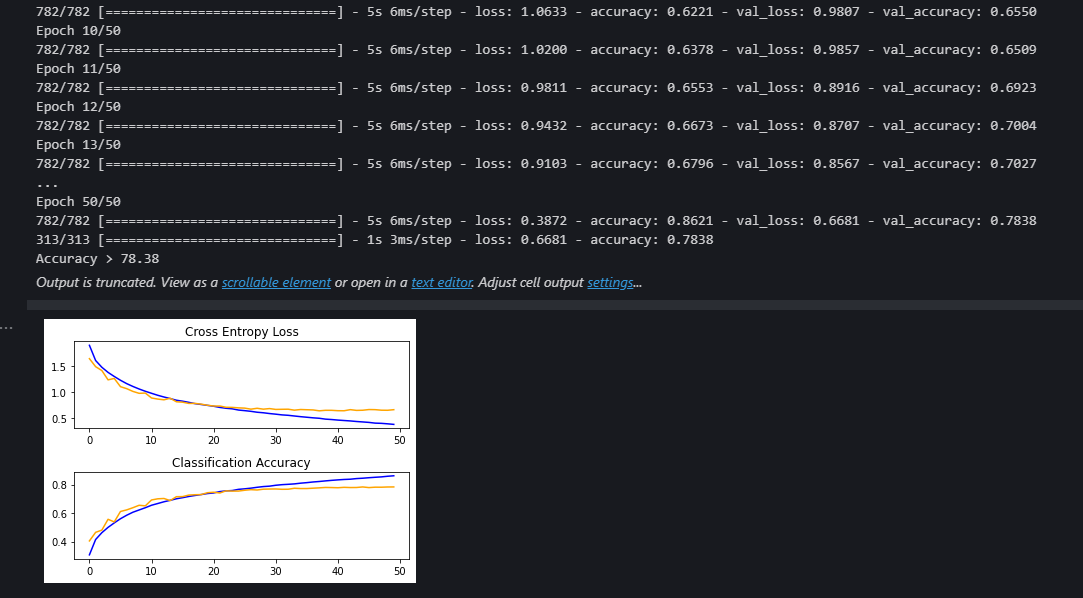
### 3 blokai: 80.91 accuracy
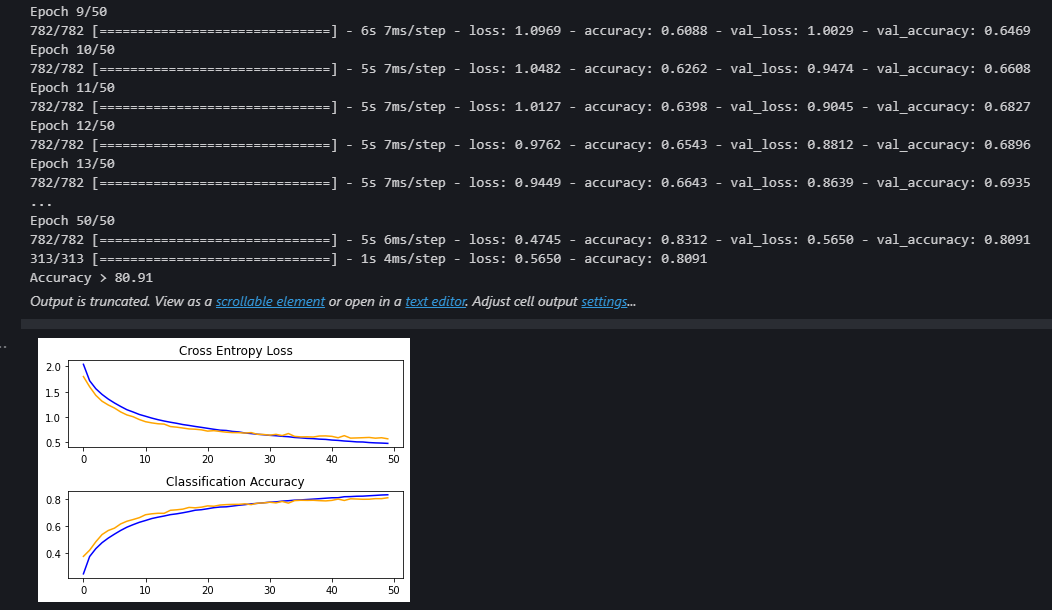
### Batch size 32:
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7630 - accuracy: 0.7346 - val_loss: 0.7657 - val_accuracy: 0.7441
### Adam optimizeris (Blogiau):
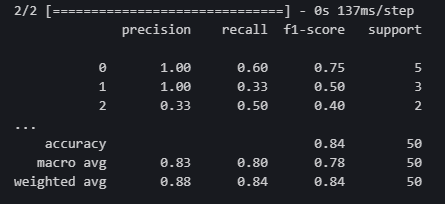

782/782 [==============================] - 6s 8ms/step - loss: 0.2545 - accuracy: 0.9139 - val_loss: 0.6877 - val_accuracy: 0.8254

### SGD optimizeris + Learning Rate 0.001 + Momentum 0.9 (Geriausias):
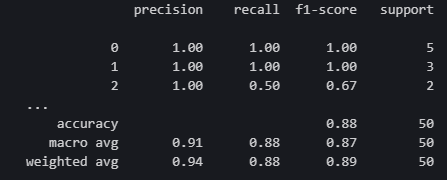

782/782 [==============================] - 5s 7ms/step - loss: 0.4823 - accuracy: 0.8294 - val_loss: 0.5543 - val_accuracy: 0.8113

### Learning rate 0.002 (Blogiau):
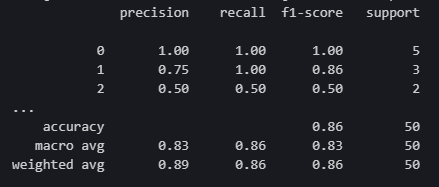

782/782 [==============================] - 5s 6ms/step - loss: 0.3168 - accuracy: 0.8857 - val_loss: 0.5721 - val_accuracy: 0.8197

### Momentum 0.8 (Blogiau):
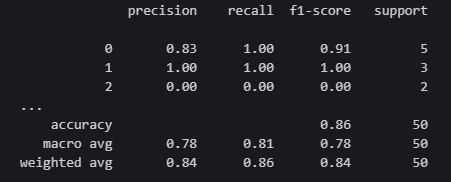

782/782 [==============================] - 6s 7ms/step - loss: 0.6547 - accuracy: 0.7677 - val_loss: 0.6534 - val_accuracy: 0.7726

### Droputai visi 0.3 (Blogiau):
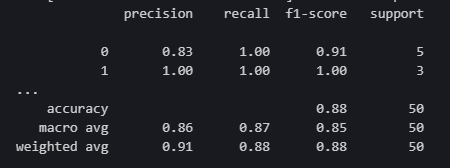

782/782 [==============================] - 6s 7ms/step - loss: 0.6219 - accuracy: 0.7815 - val_loss: 0.5803 - val_accuracy: 0.7978






In [140]:
def MLPMain():
    # užkraunam duomenis
    trainX, trainY, testX, testY = load_dataset()
    # paruošiam duomenų pixelius
    trainX, testX = prep_pixels(trainX, testX)
    # aprašom modelį
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(8000, activation='relu'))
    model.add(Dense(2000, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    # fittinam modelį
    opt = SGD(learning_rate=0.001, momentum=0.9) # SGD - Stochastic Gradient Descent, nes naudojamas didelis duomenų rinkinys, learning_rate - kaip greit koreguojami svoriai, momentum - kiek daug prideti pries tai buvusio svorio
    # categorical_crossentropy, nes turime daugiau nei 2 klases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_data=(testX, testY))
    # ivertiname modeli su testiniais duomenimis
    _, acc = model.evaluate(testX, testY)
    print('Accuracy > %.2f' % (acc * 100.0))
    # grafikai
    plotting(history)
    test_images = testX
    test_labels = testY
    # Pasiimame 15 paveikslėlių ir spausdiname jų klases
    predictions = model.predict(test_images[:15])
    print(np.argmax(predictions, axis=1))
    print(test_labels[:15])
    number_of_samples = 50
    predictions = np.argmax(model.predict(test_images[:number_of_samples]), axis=1)
    true_labels = np.argmax(test_labels[:number_of_samples], axis=1)
    print(classification_report(true_labels, predictions)) # rezultatai

    


### Adam optimizeris (Blogiau):
782/782 [==============================] - 4s 5ms/step - loss: 1.0854 - accuracy: 0.6096 - val_loss: 1.4867 - val_accuracy: 0.4994
\
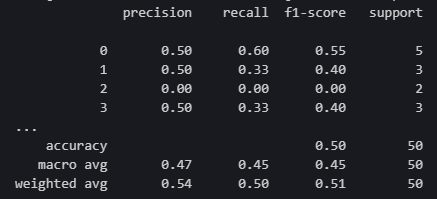

### SGD optimizeris (Geriausias optimizer):
782/782 [==============================] - 4s 5ms/step - loss: 0.9489 - accuracy: 0.6675 - val_loss: 1.3607 - val_accuracy: 0.5338
\
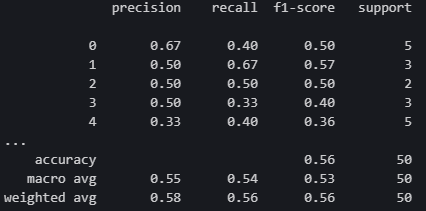

### Modelis 3000, 500, 100 (Blogiau):
782/782 [==============================] - 5s 6ms/step - loss: 0.4171 - accuracy: 0.8599 - val_loss: 1.5797 - val_accuracy: 0.5524
\
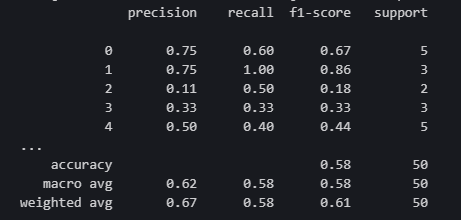

### Modelis 4000, 500 (Blogiau)
782/782 [==============================] - 4s 6ms/step - loss: 0.5692 - accuracy: 0.8129 - val_loss: 1.4031 - val_accuracy: 0.5501
\
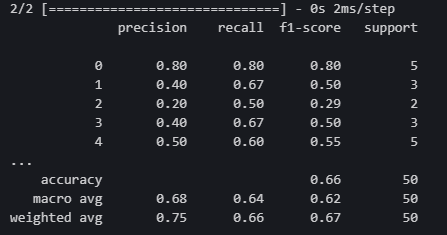

### Modelis 8000, 2000, 500 (Geriausias)
782/782 [==============================] - 5s 7ms/step - loss: 0.2648 - accuracy: 0.9168 - val_loss: 1.6412 - val_accuracy: 0.5717
\
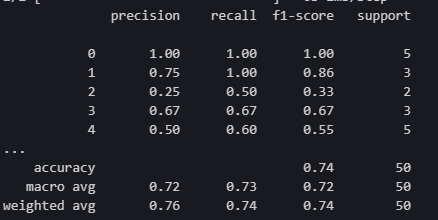

### Modelis 30000, 2000, 500 (Blogiau)
782/782 [==============================] - 12s 16ms/step - loss: 0.2455 - accuracy: 0.9235 - val_loss: 1.7593 - val_accuracy: 0.5477
\
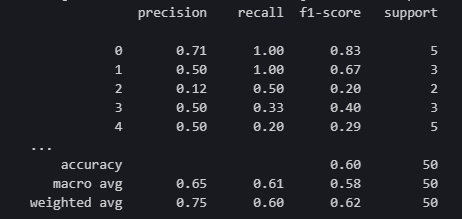


In [141]:
def kNNMain():
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import classification_report, accuracy_score

    def reshape_data_for_knn(trainX, testX):
        nsamples, nx, ny, nz = trainX.shape # nx - aukstis, ny - plotis, nz - 3 - kanalai rgb, nsamples - kiek paveikslėlių
        trainX_reshaped = trainX.reshape((nsamples, nx*ny*nz)) 
        nsamples, nx, ny, nz = testX.shape
        testX_reshaped = testX.reshape((nsamples, nx*ny*nz))
        return trainX_reshaped, testX_reshaped # pasiverciame i 1D masyva viska

    (trainX, trainY), (testX, testY) = cifar10.load_data() # užkraunamas CIFAR-10 duomenų rinkinys

    # paruošiami paveikslėliai, paverciami 1D masyva
    trainX_reshaped, testX_reshaped = reshape_data_for_knn(trainX, testX)

    # Sukuriamas kNN modelis
    knn = KNeighborsClassifier(n_neighbors=100)
    knn.fit(trainX_reshaped, trainY)

    # pasitikriname modelio tikslumą
    y_pred = knn.predict(testX_reshaped)
    print('kNN Model Accuracy: ', accuracy_score(testY, y_pred))
    print('Classification Report:', classification_report(testY, y_pred))

    import matplotlib.pyplot as plt

    # Pasiimame 10 paveikslėlių ir spausdiname jų klases ir spejimus
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.ravel()

    for i in np.arange(0, 10):
        axes[i].imshow(testX[i])
        axes[i].set_title(f"True: {testY[i]}\nPredict: {y_pred[i]}")
        axes[i].axis('off')

    plt.subplots_adjust(wspace=1)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

2023-12-05 16:36:22.801057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 [==============================] - 5s 6ms/step - loss: 2.1009 - accuracy: 0.2130 - val_loss: 1.8053 - val_accuracy: 0.3659
Epoch 2/50
782/782 [==============================] - 5s 6ms/step - loss: 1.7598 - accuracy: 0.3524 - val_loss: 1.6462 - val_accuracy: 0.3940
Epoch 3/50
782/782 [==============================] - 4s 5ms/step - loss: 1.5920 - accuracy: 0.4147 - val_loss: 1.4443 - val_accuracy: 0.4774
Epoch 4/50
782/782 [==============================] - 4s 5ms/step - loss: 1.4820 - accuracy: 0.4572 - val_loss: 1.3369 - val_accuracy: 0.5224
Epoch 5/50
782/782 [==============================] - 4s 5ms/step - loss: 1.3964 - accuracy: 0.4941 - val_loss: 1.2711 - val_accuracy: 0.5447
Epoch 6/50
782/782 [==============================] - 4s 5ms/step - loss: 1.3302 - accuracy: 0.5195 - val_loss: 1.2130 - val_accuracy: 0.5622
Epoch 7/50
782/782 [==============================] - 4s 5ms/step - loss: 1.2623 - accuracy: 0.5458 - val_loss: 1.1642 - val_accuracy: 0.5887
Epoch 8/50
782/78

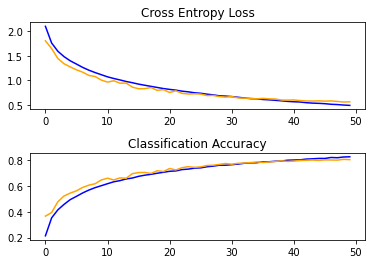

1/1 [==============================] - 0s 43ms/step
test1:
[3 8 8 8 6 6 1 6 3 1 0 9 4 7 9]
test2:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         2
           3       0.43      1.00      0.60         3
           4       0.67      0.80      0.73         5
           5       0.75      0

In [142]:
# Cia pasileisti CNN, MLP arba kNN
CNNMain()
#MLPMain()
#kNNMain()


### 2 Neighbors (Blogiau):
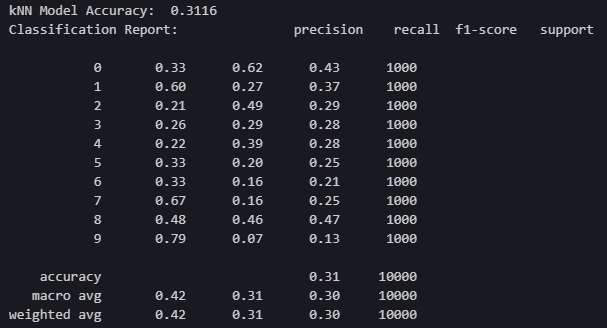
### 3 Neighbors (Blogiau):
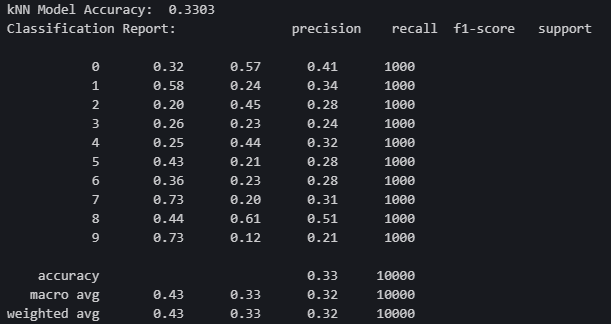
### 4 Neighbors (Blogiau):
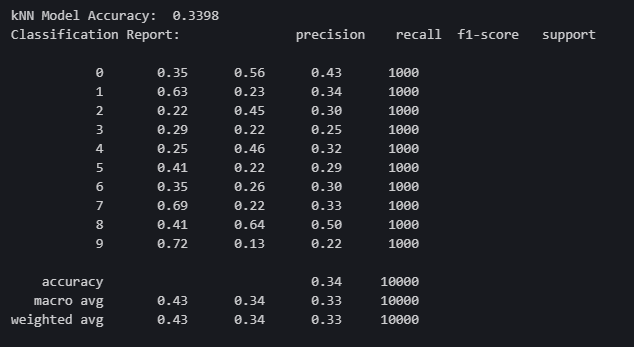
### 5 Neighbors (Blogiau):
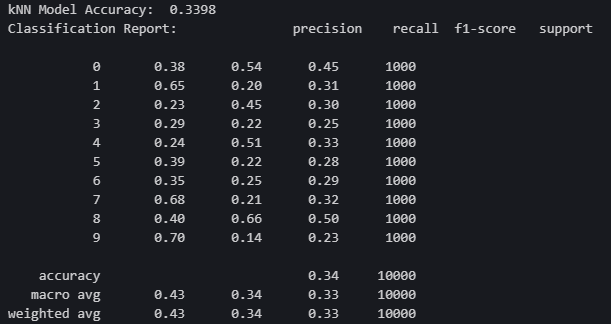
### 8 Neighbors (Geriausias):
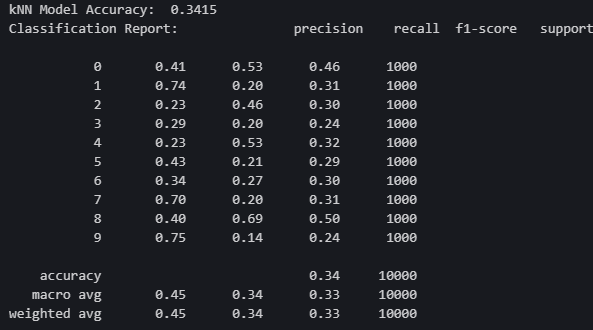
### 30 Neighbors (Blogiau):
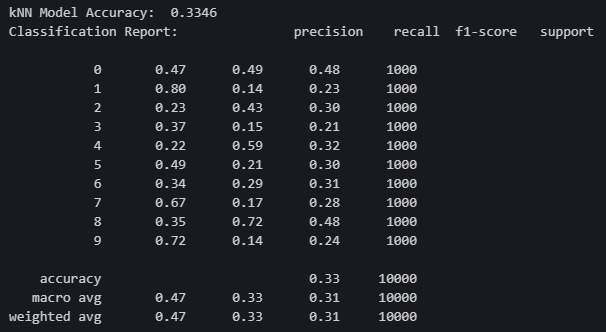


## Išvados
CNN:
Geriausia veikia su 3 VGG blokais, learning rate 0.001 ir momentum 0.9, SGD optimizeriu. 
Užtenka apie 40 epochų išgauti efektyvumui.
Accuracy 88%

Jeigu norima išgauti dar geresnius rezultatus galima įdėti L2 weight regularization per kernel_initializer argumentus modelyje. 
Galima dar atlikti Data Augmentation t.y generuoti naujas nuotraukas visaip apdorotas, apsuktas ir t.t

MLP:
Accuracy 74%
Labai jautrus pirmo sluoksnio neuronų kiekiui, veikia geriau su didėjančiu šio sluoksnio neuronų kiekiu (8000+)
Kaip ir CNN, geriausias optimizeris - SGD.
Užtenka 30-40 epochų išgauti efektyviam modeliui.


kNN:
Accuracy apie 33%
Sunku išgauti skirtumus, nes tai nėra neuroninis tinklas veikia geriausiai su 8 neighbors. Veikia labai greitai palyginus su neuroniniais tinklais.